In [1]:
# Downloaded libraries
from matplotlib import pyplot as plt
import numpy as np
import pynwb
from scipy.stats import sem

# Own libraries
import main

In [140]:
directory = "data\TestPlitt"

# # F_early files:
# handledFiles = ["sub-F1_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F2_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190407T210000_behavior+ophys_small.nwb",\
#                "sub-F5_ses-20190409T210000_behavior+ophys_small.nwb"]

# # F_late files:
# handledFiles = ["sub-F2_ses-20190417T210000_behavior+ophys_small.nwb",\
#               "sub-F5_ses-20190418T210000_behavior+ophys_small.nwb",\
#               "sub-F1_ses-20190416T210000_behavior+ophys_small.nwb",\
#               "sub-F5_ses-20190417T210000_behavior+ophys_small.nwb"]

# R_early files:
handledFiles = ["sub-R1_ses-20190211T210000_behavior+ophys_small.nwb",\
               "sub-R2_ses-20190209T210000_behavior+ophys_small.nwb",\
               "sub-R3_ses-20190211T210000_behavior+ophys_small.nwb",\
               "sub-R4_ses-20190824T210000_behavior+ophys_small.nwb"]

# # R_late files:
# handledFiles = ["sub-R1_ses-20190223T210000_behavior+ophys_small.nwb",\
#               "sub-R2_ses-20190221T210000_behavior+ophys_small.nwb",\
#               "sub-R3_ses-20190223T210000_behavior+ophys_small.nwb",\
#               "sub-R4_ses-20190905T210000_behavior+ophys_small.nwb"]


In [141]:
nNeurons = {}
deconvTraces = {}
startIndices = {}
baseMorph = {}
position = {}
nTrials = {}

readFiles = [main.getSessionHandle(file, directory) for file in handledFiles]
nFiles = len(readFiles)

for i, file in enumerate(readFiles):
    data = main.dataExtraction(readFiles[i].read())

    # nFrames = data["nFrames"]
    nNeurons[i] = data["nNeurons"]
    deconvTraces[i] = data["deconvTraces"]
    # tstartData = data["tstartData"]
    nTrials[i] = data["nTrials"]
    startIndices[i] = data["startIndices"]
    baseMorph[i] = data["baseMorph"]
    # totalMorph = data["totalMorph"]
    position[i] = data["position"]

In [142]:
dbs = {}
pbs = {}
shifted_pbs = {}
df = {}
occp = {}

for i in range(nFiles):
    dbs[i], pbs[i] = main.trialize(deconvTraces[i], position[i], startIndices[i])
    df[i], occp[i] = main.positionalBin(dbs[i], pbs[i])

In [143]:
SIMatrix = {i:np.zeros((nNeurons[i], 5)) for i in range(nFiles)}
baseMorphList = {i:baseMorph[i][startIndices[i]] for i in range(nFiles)} 
 
for sess in range(nFiles):
    for i in range(nNeurons[sess]):
        SIMatrix[sess][i,:] = main.getSpatialInformation(df[sess][:,:,i], occp[sess], baseMorphList[sess])
       

### Load in the data for SI Masks (significance check)

In [144]:
fNames = ['F_early','F_late','R_early','R_late']
tSIMasks = {filename:{} for filename in fNames}
allSIMasks = {}
for i in range(5):
    all_loaded_data = np.load(f'shufflerun{i}.npz')
    for filename in fNames:
        SIShuffles = all_loaded_data[filename]
        tSIMasks[filename][i] = np.percentile(SIShuffles,95,axis=0)


del tSIMasks['F_early'][2]
del tSIMasks['F_late'][3]
del tSIMasks['R_early'][4]
del tSIMasks['R_late'][4]

for filename in fNames:
    allSIMasks[filename] = {i:value for i,value in enumerate(tSIMasks[filename].values())}
    
        
        
# loaded_data = np.load(f'shufflerun4.npz')
# fNames = [filename for filename in loaded_data]
# SIShuffles = {i:loaded_data[fname] for i, fname in enumerate(fNames)}
# SIMasks = {i:np.percentile(SIs, 95, axis=0) for i, SIs in enumerate(SIShuffles.values())}

# This part can be manipulated to extract sessions from different saved files
SIMasks = allSIMasks['R_early']
# SIMasks

### Place cell percentage of total cell count
#### Simple method not taking into account each individual morph

In [145]:
placeCellProp = {i:np.mean(SIMatrix[i] > SIMasks[i])*100 for i in range(nFiles)}
print(f'From shuffling analysis, using SIMatrix as mask:\n{placeCellProp}')


From shuffling analysis, using SIMatrix as mask:
{0: 17.01851851851852, 1: 25.091109884041966, 2: 29.455314648334213, 3: 23.323076923076925}


#### Counting place cell amount for every individual morph

In [146]:
# Creating variable that stores the indices of the place cells (per file per basemorph)

placeCellInds = {}

for sess in range(nFiles):
    placeCellInds[sess] = {morph:np.where(SIMatrix[sess][:,m] > SIMasks[sess][:,m])[0] for m, morph in enumerate(main.baseMorphValues)}

In [147]:
placeCellCounts = {}
for sess in range(nFiles):
    placeCellCounts[sess] = {morph:len(placeCellInds[sess][morph]) for morph in main.baseMorphValues}

placeCellPct = {sess:{} for sess in range(nFiles)}
for sess in range(nFiles):
#     print(f'\nFor session {sess}:')
    for morph in main.baseMorphValues:
        placeCellPct[sess][morph] = placeCellCounts[sess][morph]*100/nNeurons[sess]
#         print(f"For base morph {morph}:\t {placeCellCounts[sess][morph]} place cells, \t {placeCellPct[sess][morph]:.2f}% of all ROIs")


### Place field location (peak location) for each area of importance (three)

In [148]:
# Needed, activity the place cells ONLY for each morph

df_placeCells = {}
baseIndices = {}
avgActivity = {}

for sess in range(nFiles):
    # extracts the sub-dataframes for the place cells for each basemorph value (all trials)
    df_placeCells[sess] = {morph:df[sess][:,:,placeCellInds[sess][morph]] for morph in main.baseMorphValues}

    # gets the indices of the trials at each base morph value
    baseIndices[sess] = {morph:np.where(baseMorphList[sess] == morph)[0] for morph in main.baseMorphValues}

    avgActivity[sess] = {morph:{} for morph in main.baseMorphValues}
    for cells in main.baseMorphValues:
        for trials in main.baseMorphValues:
            bInds = baseIndices[sess][trials]
            num = np.sum(df_placeCells[sess][cells][bInds], axis = 0)
            den = np.sum(occp[sess][bInds], axis = 0).reshape(-1,1)
            avgActivity[sess][cells][trials] = num / den


In [149]:
peaks = {}
rewardPeaks = {sess:{} for sess in range(nFiles)}
begPeaks = {sess:{} for sess in range(nFiles)}
otherPeaks = {sess:{} for sess in range(nFiles)}

for sess in range(nFiles):
    peaks[sess] = {morph:np.argmax(avgActivity[sess][morph][morph],axis=0) for morph in main.baseMorphValues}
    
#     print(f"\nFor session {sess}:")
    for morph in main.baseMorphValues:
        b_region = sum(peaks[sess][morph] < 5)
        r_region = sum((25 < peaks[sess][morph]) & (peaks[sess][morph] < 40))
        o_region = len(peaks[sess][morph]) - b_region - r_region
        rewardPeaks[sess][morph] = r_region/placeCellCounts[sess][morph]
        begPeaks[sess][morph] = b_region/placeCellCounts[sess][morph]
        otherPeaks[sess][morph] = o_region/placeCellCounts[sess][morph]
    
#         print(f"For base morph {morph}:\t {100*rewardPeaks[sess][morph]/placeCellCounts[sess][morph]:.2f} % cells tuned for reward region ({rewardPeaks[sess][morph]} cells)") 
#         print(f"For base morph {morph}:\t Reward: {100*rewardPeaks[sess][morph]:.2f} % ({r_region} cells)",end="\t")
#         print(f"Beginning: {100*begPeaks[sess][morph]:.2f} % ({b_region} cells)",end="\t")
#         print(f"Other: {100*otherPeaks[sess][morph]:.2f} % ({o_region} cells)")
        

# sum((25 < peaks[3][0]) & (peaks[3][0] < 40))
# rPeaksArr = np.array([peaks for peaks in rewardPeaks[3].values()])
# bPeaksArr = np.array([peaks for peaks in begPeaks[3].values()])
# oPeaksArr = np.array([peaks for peaks in otherPeaks[3].values()])
# print(rPeaksArr/15)
# print(bPeaksArr/5)
# print(oPeaksArr/25)



In [ ]:
# np.savez('placefieldpeaksRL.npz', reward = rewardPeaks, beginning = begPeaks, other = otherPeaks)

### Place field histogram plot, Occupancy plot, Normalized Plot

In [ ]:
nNeurons

Text(0.5, 0.98, 'Average place cell percentage per positional bin for Rare, Early Sessions')

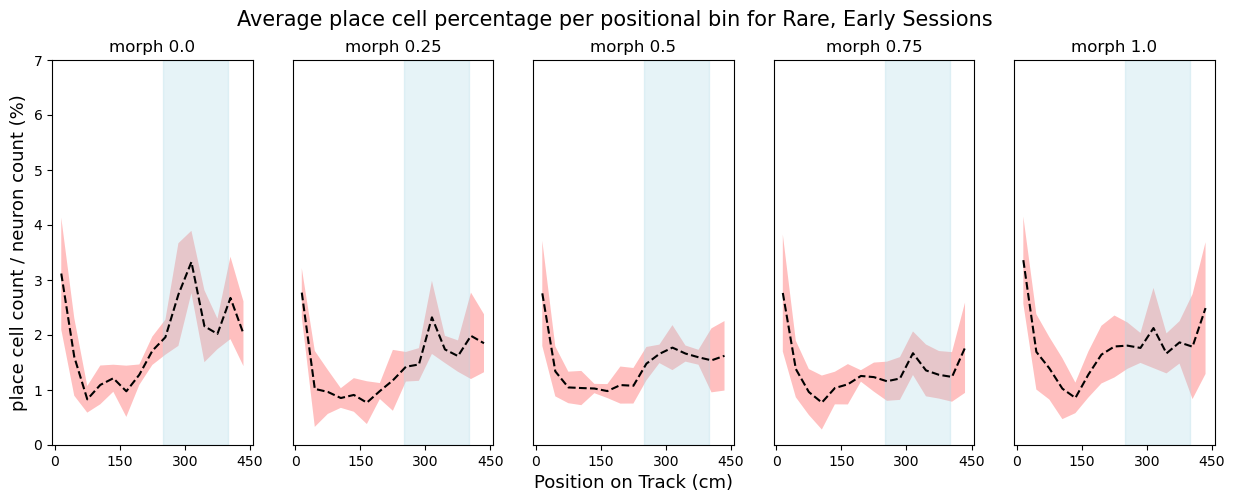

In [150]:
# # Histogram
# fig, ax = plt.subplots(nFiles, 5, figsize=(10,10))
# for row in range(nFiles):
#     for col, morph in enumerate(main.baseMorphValues):
#         ax[row,col].hist(peaks[row][morph], bins = 15)
#         if col == 0:
#             ax[row,col].set_ylabel(f'Session {row}')
#         if row == 0:
#             ax[row,col].set_title(f'morph {morph}')

# fig, ax = plt.subplots(nFiles, 5, figsize=(10,10))
avgCellCount = {}
for sess in range(nFiles):
    for i, morph in enumerate(main.baseMorphValues):
        cellCounts = np.histogram(np.argmax(avgActivity[sess][morph][morph],axis=0),bins=15)[0]/(0.01*nNeurons[sess])
#         ax[sess][i].plot(cellCounts)
        if sess == 0:
            avgCellCount[morph] = cellCounts
        else:
            avgCellCount[morph] = np.vstack((avgCellCount[morph], cellCounts))            

fig, ax = plt.subplots(1, 5, figsize=(15,5), sharey=True)
for i, morph in enumerate(main.baseMorphValues):
    means = np.mean(avgCellCount[morph],axis=0)
    stds = np.std(avgCellCount[morph],axis=0)
    ax[i].plot(30*(0.5+np.array(range(15))),means,"--k")
    ax[i].fill_between(30*(0.5+np.array(range(15))),means-stds,means+stds,alpha=0.25,facecolor='red')
    ax[i].set_xticks([0,150,300,450])
    ax[i].set_title(f"morph {morph}", fontsize=12)
    ax[i].axvspan(250, 400, color='lightblue', alpha=0.3, label='Reward Region')
    
    if i > 0:
        ax[i].tick_params(left=False, which='both')  # Hide tick markers on the left side

ax[2].set_xlabel("Position on Track (cm)", fontsize=13)
ax[0].set_ylim(0,7)
ax[0].set_ylabel("place cell count / neuron count (%)", fontsize=13)
plt.suptitle("Average place cell percentage per positional bin for Rare, Early Sessions", fontsize=15)    


In [255]:
np.mean(occp[sess], axis=0).shape
# np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1).shape

(45,)

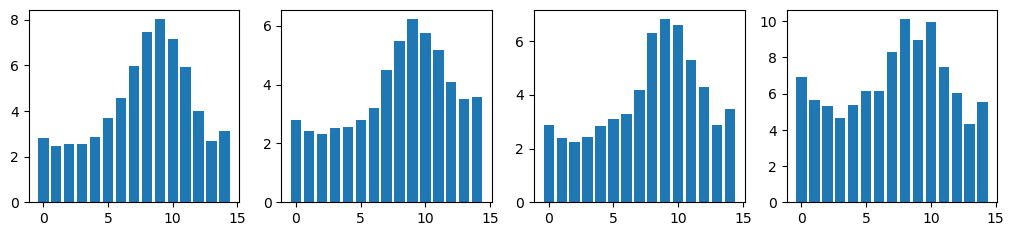

In [219]:
# Occupancy
fig, ax = plt.subplots(1, nFiles, figsize=(12.5,2.5))

for sess in range(nFiles):
    toPlot = np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1) # inner reshape and mean is to discretoze the array into 15 bins
    ax[sess].bar(range(15),toPlot)

Text(0.5, 0.98, 'Average place cell percentage per positional bin normalized by occupancy for Rare, Early sessions')

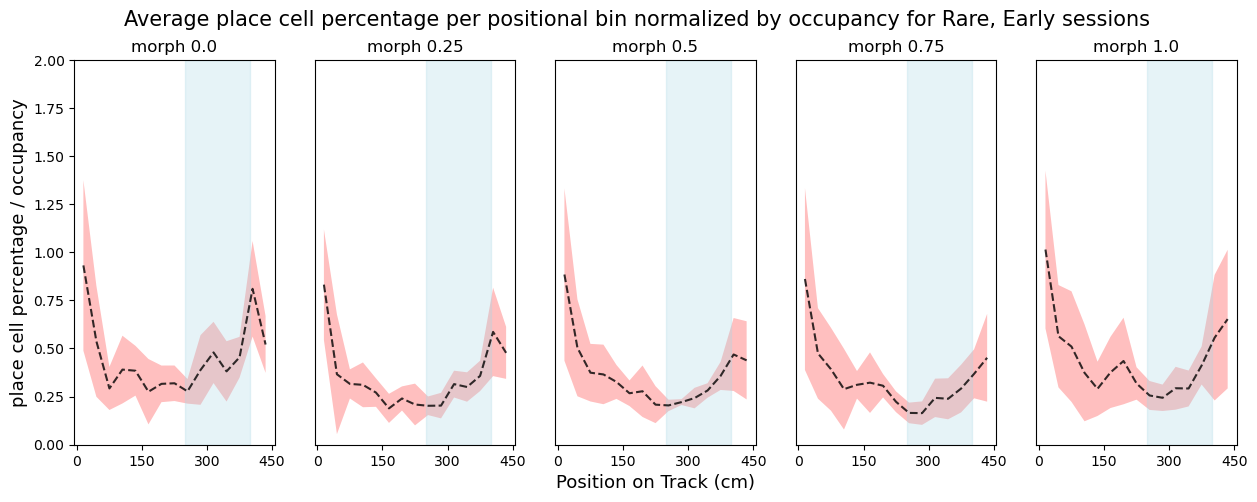

In [151]:
# Plotting the cell count normalized by the average occupancy for every session (for all basemorphs)
# fig, ax = plt.subplots(nFiles,len(main.baseMorphValues), figsize=(10,10))

avgcellToOccpR = {}
for sess in range(nFiles):
    for i, morph in enumerate(main.baseMorphValues):
        cellCounts = np.histogram(np.argmax(avgActivity[sess][morph][morph],axis=0),bins=15)[0]/(0.01*nNeurons[sess])
        binnedPos = np.mean(np.mean(occp[sess], axis=0).reshape(-1,3), axis=1)
#         ax[sess][i].plot(cellCounts/binnedPos)
        if sess == 0:
            avgcellToOccpR[morph] = cellCounts/binnedPos
        else:
            avgcellToOccpR[morph] = np.vstack((avgcellToOccpR[morph], cellCounts/binnedPos))
            
# Plotting the average normalized cell count across sessions
fig, ax = plt.subplots(1,5, figsize=(15,5), sharey = True)
for i, morph in enumerate(main.baseMorphValues):
    means = np.mean(avgcellToOccpR[morph],axis=0)
    stds = np.std(avgcellToOccpR[morph],axis=0)
    ax[i].plot(30*(0.5+np.array(range(15))),means,'--k', alpha=0.8)
    ax[i].fill_between(30*(0.5+np.array(range(15))),means-stds,means+stds,alpha=0.25,facecolor='red')
    ax[i].set_xticks([0,150,300,450])
    ax[i].set_title(f"morph {morph}", fontsize=12)
    ax[i].axvspan(250, 400, color='lightblue', alpha=0.3, label='Reward Region')
        
    if i > 0:
        ax[i].tick_params(left=False, which='both')  # Hide tick markers on the left side

ax[2].set_xlabel("Position on Track (cm)", fontsize=13)
ax[0].set_ylim(0,2)
ax[0].set_ylabel("place cell percentage / occupancy", fontsize=13)
plt.suptitle("Average place cell percentage per positional bin normalized by occupancy for Rare, Early sessions", fontsize=15)

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42])

### Intrasessional remapping

In [240]:
import scipy
import numpy as np


sample1 = np.random.rand(100)
sample2 = sample1 + 0.09

print(scipy.stats.ttest_ind(sample1, sample2))
print(scipy.stats.ttest_ind(sample1, sample2, alternative="less"))

TtestResult(statistic=-2.416759328324215, pvalue=0.016566239436983387, df=198.0)
TtestResult(statistic=-2.416759328324215, pvalue=0.008283119718491693, df=198.0)


In [ ]:
original = np.asarray([0.9, 0.05, 0.02, 0.01, 0.005, 0.00499])
new = scipy.stats.false_discovery_control(original)
print(new / original)
print(new)

In [81]:
import scipy
# scipy.__version__

### Intersessional remapping

In [ ]:
# np.savez("placecellpctFL.npz", percentages = placeCellPct)

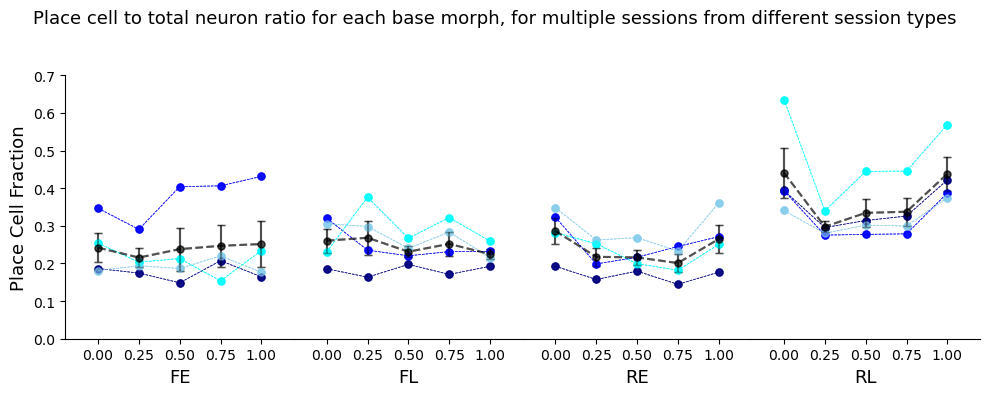

In [176]:
# plt.plot()
colours = ['navy', 'blue', 'skyblue', 'aqua']
placeCellPct_t = {}
for morph in main.baseMorphValues:
    placeCellPct_t[morph] = [entry[morph] for entry in placeCellPct.values()]


fig, ax = plt.subplots(1,4,figsize=(10,4), sharey = True)
names = ['FE','FL','RE','RL']
for i, n in enumerate(names):
    loaded_data = np.load(f"placecellpct{n}.npz", allow_pickle=True)
    ppct = loaded_data['percentages'].item()
    placeCellPct_t = {}
    for morph in main.baseMorphValues:
        placeCellPct_t[morph] = [entry[morph] for entry in ppct.values()]
    
    means = [np.mean(np.array(value)/100) for value in placeCellPct_t.values()]
    errors = [sem(np.array(value)/100) for value in placeCellPct_t.values()]
#     for key, values in placeCellPct_t.items():
#         ax[i].scatter([key] * len(values), np.array(values)/100, c=colours)
    for key, values in ppct.items():    
        x = list(ppct[0].keys())
        if n == 'FL':
            ax[i].plot(x, np.array(list(ppct[2].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[0])
            ax[i].plot(x, np.array(list(ppct[0].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[1])
            ax[i].plot(x, np.array(list(ppct[1].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[2])
            ax[i].plot(x, np.array(list(ppct[3].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[3])
        else:    
            ax[i].plot(x, np.array(list(ppct[0].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[0])
            ax[i].plot(x, np.array(list(ppct[1].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[1])
            ax[i].plot(x, np.array(list(ppct[2].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[2])
            ax[i].plot(x, np.array(list(ppct[3].values()))/100, '--o', lw=0.5, ms = 5, alpha=0.5, c = colours[3])

#         # Calculate mean and standard error for each x-label
#         mean = np.mean(np.array(values)/100)
#         error = sem(np.array(values)/100)

        # Plot the mean with whiskers to represent the error
        ax[i].errorbar(x, means, yerr=errors, fmt='--o', markersize=5, color='black', capsize=3, alpha=0.25)

        ax[i].set_xticks(x)  # Set custom x-axis ticks
        ax[i].set_xlim(min(x) - 0.2, max(x) + 0.2)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(n, fontsize=13)
        
        if i > 0:
            ax[i].spines['left'].set_visible(False)
            ax[i].tick_params(left=False, which='both')  # Hide tick markers on the left side
# plt.errorbar()    
ax[0].set_ylim(0, 0.70)
ax[0].set_ylabel('Place Cell Fraction',  fontsize=13)
plt.suptitle("Place cell to total neuron ratio for each base morph, for multiple sessions from different session types\n", fontsize=13)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
# ax.set_xlabel('Dictionary Keys')
# ax.set_ylabel('Values')
# ax.set_title('Scatter Plot of Dictionary Values')
# ax.set_xticks(list(placeCellPct_t.keys()))  # Set custom x-axis ticks
# ax.set_xlim(min(placeCellPct_t.keys()) - 0.5, max(placeCellPct_t.keys()) + 0.5)

Text(0.5, 0.98, 'Fraction of place cells in different regions of the track normalized by region length')

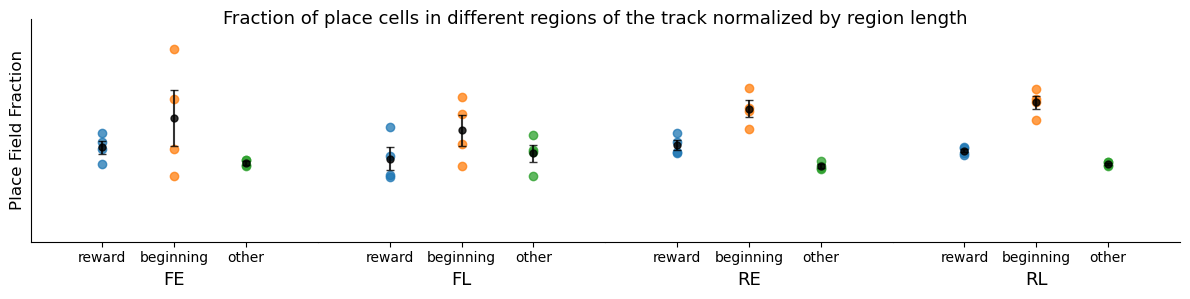

In [187]:
fig, ax = plt.subplots(1,4, figsize=(12,3), sharey = True)
names = ['FE','FL','RE','RL']

for i, n in enumerate(names):
    loaded_data = np.load(f"placefieldpeaks{n}.npz", allow_pickle = True)
    peakfiles = loaded_data.files

    peaks = {}
    for peakarea in peakfiles:
        peakfractions = loaded_data[peakarea].item()
        meanfractions = [np.mean(list(inner_dict.values())) for inner_dict in peakfractions.values()]
        peaks[peakarea] = meanfractions
    
    for key, values in peaks.items():
        if key == "reward": 
            values = np.array(values)*45/15
        if key == "beginning": 
            values = np.array(values)*45/5
        if key == "other": 
            values = np.array(values)*45/25
        
        ax[i].scatter([key]*len(values), values, alpha = 0.75)
        # Calculate mean and standard error for each x-label
        mean = np.mean(values)
        error = sem(values)

        # Plot the mean with whiskers to represent the error
        ax[i].errorbar(key, mean, yerr=error, fmt='o', markersize=5, color='black', capsize=3, alpha=0.8)
    
    ax[i].set_xlim(-1,len(peakfiles))
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlabel(n, fontsize=13)
    
    if i > 0:
        ax[i].spines['left'].set_visible(False)
        ax[i].tick_params(left=False, which='both')  # Hide tick markers on the left side

ax[0].set_yticks([])
ax[0].tick_params(left=False, which='both')  # Hide tick markers on the left side

ax[0].set_ylim(0, 2.5)
ax[0].set_ylabel('Place Field Fraction',  fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0)  
plt.suptitle("Fraction of place cells in different regions of the track normalized by region length", fontsize=13)




In [264]:
names = ['FE','FL','RE','RL']
import scipy
t_tests = {name:{} for name in names}
p_values = np.array([])
for i, n in enumerate(names):
    loaded_data = np.load(f"placefieldpeaks{n}.npz", allow_pickle = True)
    peakfiles = loaded_data.files

    peaks = {}
    for peakarea in peakfiles:
        peakfractions = loaded_data[peakarea].item()
        meanfractions = [np.mean(list(inner_dict.values())) for inner_dict in peakfractions.values()]
        peaks[peakarea] = meanfractions

    for i, peakarea1 in enumerate(peakfiles[:-1]):
        for peakarea2 in peakfiles[i+1:]:
            sample1 = peaks[peakarea1]
            sample2 = peaks[peakarea2]
            t_test = scipy.stats.ttest_ind(sample1, sample2)
            p_values = np.append(p_values,t_test[1])
            t_tests[n][f"{peakarea1}_{peakarea2}"] = t_test[1]
            

print(f"The p_values in the original (uncorrected for length) case are:\n{p_values}\n where the order is:\n{t_tests}")
new = scipy.stats.false_discovery_control(p_values)
print(f"The new p_values corrected for number of comparisons is:\n{new}")

        



The p_values in the original (uncorrected for length) case are:
[3.45082887e-03 2.11002495e-03 9.47902362e-05 1.12879260e-02
 1.25513696e-02 3.14118993e-04 7.39698771e-05 1.81063937e-03
 9.49498401e-07 3.51776580e-06 3.88037240e-06 8.21647294e-08]
 where the order is:
{'FE': {'reward_beginning': 0.0034508288715519196, 'reward_other': 0.0021100249518214145, 'beginning_other': 9.479023620840833e-05}, 'FL': {'reward_beginning': 0.011287926031103202, 'reward_other': 0.012551369600488955, 'beginning_other': 0.00031411899318278374}, 'RE': {'reward_beginning': 7.396987705586444e-05, 'reward_other': 0.0018106393705815283, 'beginning_other': 9.494984009063748e-07}, 'RL': {'reward_beginning': 3.5177657988693898e-06, 'reward_other': 3.880372403602289e-06, 'beginning_other': 8.216472940034379e-08}}
The new p_values corrected for number of comparisons is:
[4.14099465e-03 2.81336660e-03 1.89580472e-04 1.23141011e-02
 1.25513696e-02 5.38489703e-04 1.77527705e-04 2.71595906e-03
 5.69699041e-06 1.16411

In [267]:
names = ['FE','FL','RE','RL']
import scipy
t_tests = {name:{} for name in names}
p_values = np.array([])
for i, n in enumerate(names):
    loaded_data = np.load(f"placefieldpeaks{n}.npz", allow_pickle = True)
    peakfiles = loaded_data.files

    peaks = {}
    for peakarea in peakfiles:
        peakfractions = loaded_data[peakarea].item()
        meanfractions = [np.mean(list(inner_dict.values())) for inner_dict in peakfractions.values()]
        
        if peakarea == "reward": 
            meanfractions = np.array(meanfractions)*45/15
        if peakarea == "beginning": 
            meanfractions = np.array(meanfractions)*45/5
        if peakarea == "other": 
            meanfractions = np.array(meanfractions)*45/25
        
        peaks[peakarea] = meanfractions

    for i, peakarea1 in enumerate(peakfiles[:-1]):
        for peakarea2 in peakfiles[i+1:]:
            sample1 = peaks[peakarea1]
            sample2 = peaks[peakarea2]
            t_test = scipy.stats.ttest_ind(sample1, sample2)
            p_values = np.append(p_values,t_test[1])
            t_tests[n][f"{peakarea1}_{peakarea2}"] = t_test[1]
            

print(f"The p_values in the corrected for length case are:\n{p_values}\n where the order is:\n{t_tests}")
new = scipy.stats.false_discovery_control(p_values)
print(f"These new p_values corrected for number of comparisons are:\n{new}")
        



The p_values in the corrected for length case are:
[3.53043877e-01 6.25796248e-02 1.65130264e-01 1.94671194e-01
 7.33147543e-01 2.36097805e-01 9.79170069e-03 5.69847194e-03
 5.71674429e-04 3.43591337e-04 6.03825834e-04 7.86652108e-05]
 where the order is:
{'FE': {'reward_beginning': 0.35304387721168135, 'reward_other': 0.06257962484374965, 'beginning_other': 0.16513026359475058}, 'FL': {'reward_beginning': 0.1946711938430708, 'reward_other': 0.7331475425426099, 'beginning_other': 0.2360978054637202}, 'RE': {'reward_beginning': 0.009791700689172653, 'reward_other': 0.005698471942835551, 'beginning_other': 0.0005716744289028893}, 'RL': {'reward_beginning': 0.0003435913370400223, 'reward_other': 0.0006038258336919055, 'beginning_other': 7.866521079950367e-05}}
These new p_values corrected for number of comparisons are:
[0.38513878 0.10727936 0.2476954  0.25956159 0.73314754 0.28331737
 0.0195834  0.01367633 0.00181148 0.00181148 0.00181148 0.00094398]


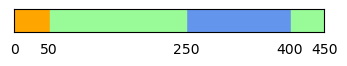

In [218]:
fig, ax = plt.subplots(1,1,figsize=(4,0.3))
ax.plot(np.arange(451), alpha=0)
ax.set_yticks([])
ax.set_xticks([0,50,250,400,450])
ax.axvspan(250, 400, color='cornflowerblue', label='Reward Region')
ax.axvspan(0, 50, color='orange',label="Beginning Region")
ax.axvspan(51,249, color='palegreen',label="Other Region")
ax.axvspan(401,450, color='palegreen',label="Other Region")
ax.set_xlim(0,450)
ax.tick_params(bottom=False, which='both')  # Hide tick markers on the left side



plt.show()
